In [1]:
import tensorflow as tf
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Käytä esikoulutettua mallia (esim. VGG16) piirteiden irrottamiseen
Kouluta vain oma luokittelija (fully connected) irrotettujen piirteiden päälle
Vertaa suorituskykyä ensimmäiseen malliin

In [2]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])
train_dataset = image_dataset_from_directory("kuvat/train", image_size=(224, 224), batch_size=32)
validation_dataset = image_dataset_from_directory("kuvat/validation", image_size=(224, 224), batch_size=32)
test_dataset = image_dataset_from_directory("kuvat/test", image_size=(224, 224), batch_size=32)


train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

conv_base = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_base.summary()


Found 126 files belonging to 3 classes.
Found 27 files belonging to 3 classes.
Found 27 files belonging to 3 classes.

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
       

In [3]:
@tf.function(reduce_retracing=True)
def extract_features(images):
    return conv_base(images)

def get_features_and_labels(dataset):
    all_features, all_labels = [], []
    for images, labels in dataset:
        if labels is None:
            continue
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = extract_features(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return tf.concat(all_features, axis=0), tf.concat(all_labels, axis=0)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)


In [4]:
inputs = keras.Input(shape=(7, 7, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [5]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="feature_extraction.keras", save_best_only=True, monitor="val_loss")]

start_time = time.time()

history = model.fit(train_features, train_labels, epochs=20, validation_data=(val_features, val_labels), callbacks=callbacks, verbose=1)

training_time = time.time() - start_time

test_loss, test_acc = model.evaluate(test_features, test_labels)

# Save results
np.savez("VGG_kuvantunnistus_results.npz",
         test_acc=test_acc,
         test_loss=test_loss,
         training_time=training_time,
         history=history.history)

Epoch 1/20


4/4 [==============================] - 1s 182ms/step - loss: 25.4346 - accuracy: 0.3651 - val_loss: 12.2107 - val_accuracy: 0.4815
Epoch 2/20
4/4 [==============================] - 0s 117ms/step - loss: 5.6625 - accuracy: 0.7778 - val_loss: 3.9590 - val_accuracy: 0.7407
Epoch 3/20
4/4 [==============================] - 0s 115ms/step - loss: 1.6248 - accuracy: 0.9048 - val_loss: 3.9501 - val_accuracy: 0.7037
Epoch 4/20
4/4 [==============================] - 0s 65ms/step - loss: 0.4976 - accuracy: 0.9127 - val_loss: 4.7699 - val_accuracy: 0.7037
Epoch 5/20
4/4 [==============================] - 0s 68ms/step - loss: 0.5423 - accuracy: 0.9524 - val_loss: 9.9944 - val_accuracy: 0.7037
Epoch 6/20
4/4 [==============================] - 0s 63ms/step - loss: 0.0282 - accuracy: 0.9921 - val_loss: 13.8024 - val_accuracy: 0.7407
Epoch 7/20
4/4 [==============================] - 0s 65ms/step - loss: 0.2270 - accuracy: 0.9841 - val_loss: 14.5885 - val_accuracy: 0.7037
Epoch 8/20
4/4 [==

In [7]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 0s 24ms/step - loss: 6.5529 - accuracy: 0.7778
Test accuracy: 0.778


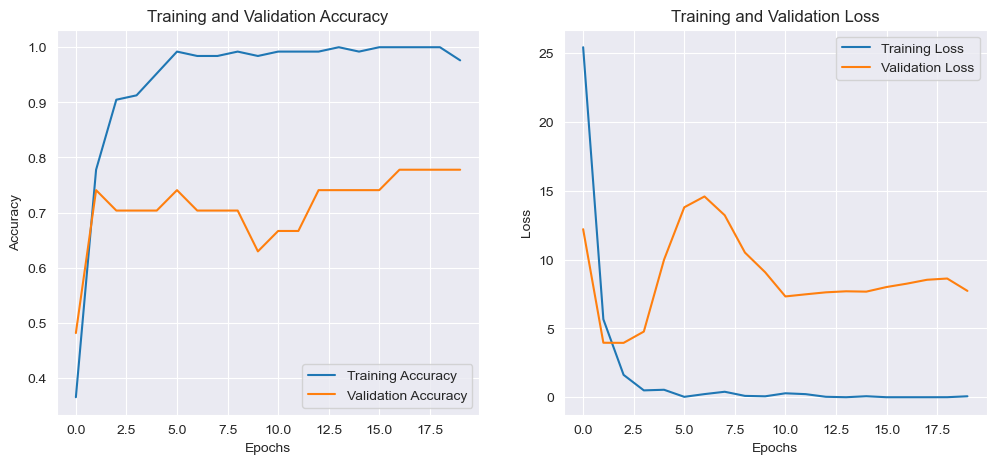

1/1 [==============================] - 0s 61ms/step
              precision    recall  f1-score   support

    haarukka       0.60      1.00      0.75         9
     lusikka       1.00      0.67      0.80         9
      veitsi       1.00      0.67      0.80         9

    accuracy                           0.78        27
   macro avg       0.87      0.78      0.78        27
weighted avg       0.87      0.78      0.78        27



In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

y_pred = np.argmax(model.predict(test_features), axis=1)
print(classification_report(test_labels, y_pred, target_names=['haarukka', 'lusikka', 'veitsi']))
